1) sales_df_train.csv –данные по продажам за скользящий год для обучения.
st_id – захэшированное id магазина; 12 магазинов
pr_sku_id – захэшированное id товара; 1991
date – дата;
pr_sales_type_id – флаг наличия промо;
pr_sales_in_units – число проданных товаров без признака промо;
pr_promo_sales_in_units – число проданных товаров с признаком промо;
pr_sales_in_rub – продажи без признака промо в РУБ;
pr_promo_sales_in_rub – продажи с признаком промо в РУБ;

2) pr_df.csv – данные по товарной иерархии.
От большего к меньшему pr_group_id - pr_cat_id - pr_subcat_id - pr_sku_id.

pr_group_id – захэшированная группа товара; 9
pr_cat_id – захэшированная категория товара; 43
pr_subcat_id – захэшированная подкатегория товара; 167
pr_sku_id – захэшированное id товара; 1991
pr_uom_id (маркер, обозначающий продаётся товар на вес или в ШТ). - значения 1 и 17

3) pr_st.csv – данные по магазинам.

st_id – захэшированное id магазина; 12 магазинов
st_city_id – захэшированное id города; 7 городов
st_division_code id – захэшированное id дивизиона; 6 дивизионов
st_type_format_id – id формата магазина; 3
st_type_loc_id – id тип локации/окружения магазина; 3
st_type_size_id – id типа размера магазина; 6 типов
st_is_active – флаг активного магазина на данный момент. 2

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

In [21]:
df_train = pd.read_csv('sales_df_train.csv')
pr_df = pd.read_csv('pr_df.csv')
st_df = pd.read_csv('st_df.csv')

In [22]:
temp_df = pd.merge(df_train, pr_df, on='pr_sku_id')
df = pd.merge(temp_df, st_df, on='st_id')
del temp_df

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883015 entries, 0 to 883014
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   st_id                    883015 non-null  object 
 1   pr_sku_id                883015 non-null  object 
 2   date                     883015 non-null  object 
 3   pr_sales_type_id         883015 non-null  int64  
 4   pr_sales_in_units        883015 non-null  float64
 5   pr_promo_sales_in_units  883015 non-null  float64
 6   pr_sales_in_rub          883015 non-null  float64
 7   pr_promo_sales_in_rub    883015 non-null  float64
 8   pr_group_id              883015 non-null  object 
 9   pr_cat_id                883015 non-null  object 
 10  pr_subcat_id             883015 non-null  object 
 11  pr_uom_id                883015 non-null  int64  
 12  st_city_id               883015 non-null  object 
 13  st_division_code         883015 non-null  object 
 14  st_t

In [35]:
df['date'] = pd.to_datetime(df['date'])
df_hash_recovered.head()

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active
0,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-20,1,5.0,5.0,825.0,825.0,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1
1,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2023-02-02,1,1.0,1.0,107.0,107.0,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1
2,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-09,1,1.0,1.0,167.0,167.0,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1
3,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2023-06-22,0,0.0,0.0,79.0,0.0,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1
4,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2023-06-30,1,25.0,25.0,3766.0,3766.0,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1


In [ ]:
# Создаем копию датафрейма
df_num = df.copy()

# Создаем словарь для хранения объектов LabelEncoder для каждого столбца
label_encoders = {}

for column_name in df.columns:
    if df[column_name].dtype == 'object':  # Проверяем, является ли столбец хэшированным
        le = LabelEncoder()
        df_num[column_name] = le.fit_transform(df[column_name])
        label_encoders[column_name] = le

In [22]:
df_num.to_csv('df_lenta.csv', index=False)

In [23]:
pd.read_csv('df_lenta.csv')

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active
0,0,0,2022-10-20,1,5.0,5.0,825.0,825.0,0,0,0,1,0,0,1,1,8,1
1,0,0,2023-02-02,1,1.0,1.0,107.0,107.0,0,0,0,1,0,0,1,1,8,1
2,0,0,2022-10-09,1,1.0,1.0,167.0,167.0,0,0,0,1,0,0,1,1,8,1
3,0,0,2023-06-22,0,0.0,0.0,79.0,0.0,0,0,0,1,0,0,1,1,8,1
4,0,0,2023-06-30,1,25.0,25.0,3766.0,3766.0,0,0,0,1,0,0,1,1,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
883010,11,1844,2022-08-31,0,2.0,0.0,268.0,0.0,2,6,26,1,5,4,4,3,32,0
883011,11,1844,2022-09-08,0,2.0,0.0,294.0,0.0,2,6,26,1,5,4,4,3,32,0
883012,11,1844,2022-08-24,1,7.0,7.0,670.0,670.0,2,6,26,1,5,4,4,3,32,0
883013,11,1844,2022-09-02,1,5.0,5.0,476.0,476.0,2,6,26,1,5,4,4,3,32,0


In [61]:
sales_and_goods_id = df_num[['pr_sku_id', 'pr_promo_sales_in_rub', 'pr_promo_sales_in_units']]
sales_and_goods_id.groupby('pr_sku_id').sum().sort_values('pr_promo_sales_in_rub', ascending=False).head(11)

,pr_promo_sales_in_rub,pr_promo_sales_in_units
pr_sku_id,,
56,10574655.0,20845.0
408,6918779.0,13151.0
246,6646468.0,47472.0
91,6471770.0,75979.0
205,5465059.0,43004.0
1358,5028315.0,19846.0
124,4694261.0,27105.0
1359,4493539.0,22857.0
143,4218399.0,17184.0


In [62]:
sales_and_goods_id.groupby('pr_sku_id').sum().sort_values('pr_promo_sales_in_units', ascending=False).head(11)

,pr_promo_sales_in_rub,pr_promo_sales_in_units
pr_sku_id,,
91,6471770.0,75979.0
246,6646468.0,47472.0
205,5465059.0,43004.0
154,1119677.0,40725.0
79,3461061.0,28092.0
124,4694261.0,27105.0
200,2766537.0,26879.0
133,3751273.0,26502.0
151,2858860.0,26356.0


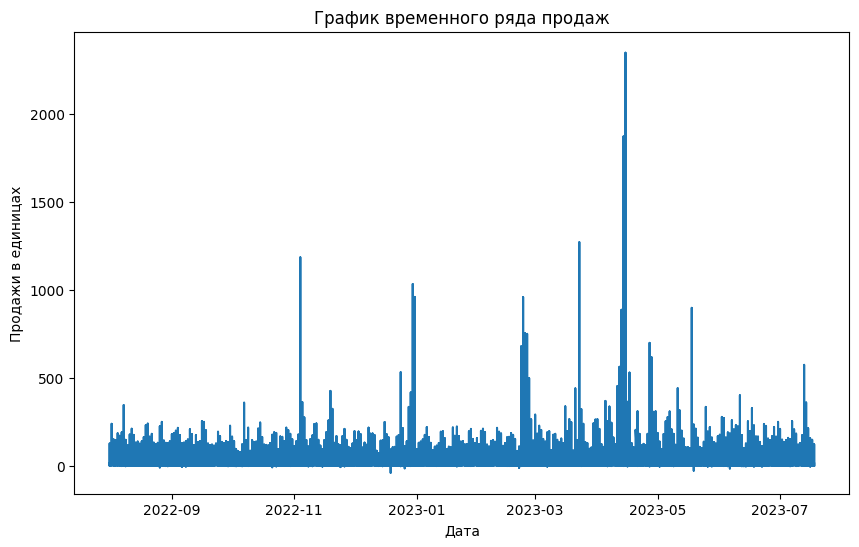

In [19]:
# Сортируем DataFrame по дате
df = df.sort_values('date')

# Строим график
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['pr_sales_in_units'])
plt.xlabel('Дата')
plt.ylabel('Продажи в единицах')
plt.title('График временного ряда продаж')
plt.show()

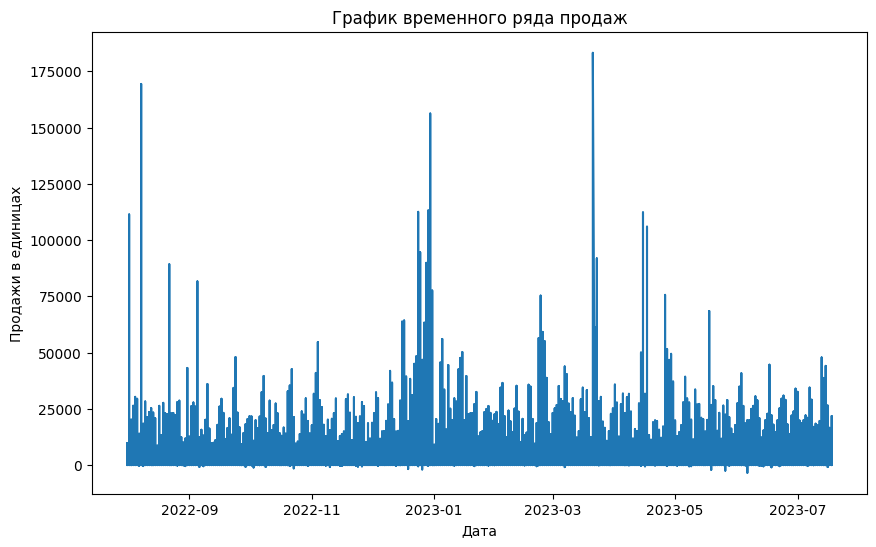

In [18]:
# Сортируем DataFrame по дате
df = df.sort_values('date')

# Строим график
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['pr_sales_in_rub'])
plt.xlabel('Дата')
plt.ylabel('Продажи в единицах')
plt.title('График временного ряда продаж')
plt.show()

In [68]:
df_num[df_num['pr_sales_in_units']==df_num['pr_sales_in_units'].max()]

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active
681320,4,846,2023-04-15,1,2348.0,2348.0,62429.0,62429.0,1,3,66,17,4,2,1,1,12,1


In [70]:
62429/2348

26.588160136286202